# BC replication study

In [2]:
from wb_dataset import *
from wb_dataset_helpers import *
from neural_networks import *

from tqdm import tqdm
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

# Increase resolution of plots
plt.rcParams['figure.dpi'] = 150

# Show more columns
pd.set_option('display.max_column',None)

### Initialize global parameters

In [4]:
# dataset parameters
db_size = 2400 #or 50000
n_noise=52 #number of noise variables

# Network parameters
hidden_layers = [(12), (24, 6), (24,10,3)]
activation = 'logistic'
max_iter = 50000
learning_rate_init = 0.001
solver = 'adam'
batch_size = 50

### Create data

In [5]:
# Type A datasets
train_A_df = create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise)
test_A_df = create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise)

# Type B datasets
train_B_df = create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise)
test_B_df = create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise)

# Age-Gender and Patient-Distance datasets
ag_df = create_age_gender_dataset(db_size=1000, n_noise=n_noise)
pd_df = create_patient_distance_dataset(db_size=1000, n_noise=n_noise)

### Preprocess 

In [6]:
# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))

# Apply preprocessing to all data
train_A_X, train_A_y = preprocess(train_A_df, scaler)
test_A_X, test_A_y = preprocess(test_A_df, scaler)
train_B_X, train_B_y = preprocess(train_B_df, scaler)
test_B_X, test_B_y = preprocess(test_B_df, scaler)
ag_X, ag_y = preprocess(ag_df, scaler)
pd_X, pd_y = preprocess(pd_df, scaler)

### Train Networks

In [7]:
def create_network(layers):
    return MLPClassifier(activation=activation, hidden_layer_sizes=layers, 
                         max_iter=max_iter, learning_rate_init=learning_rate_init,
                         solver=solver, batch_size=batch_size)

def train_networks(nn, X, y):
    nn.fit(X, y)
    return nn

In [8]:
# Create and train the neural networks on training set A
neural_nets_A = [create_network(hls) for hls in hidden_layers]   
neural_nets_A = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_A_X, train_A_y) 
                                 for nn in tqdm(neural_nets_A))

# # Create and train the neural networks on training set B
neural_nets_B = [create_network(hls) for hls in hidden_layers]
neural_nets_B = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_B_X, train_B_y) 
                                 for nn in tqdm(neural_nets_B))

100%|██████████| 3/3 [00:00<?, ?it/s]


### Test the performance (accuracies)

In [9]:
# Store the predictions of the networks in their respective dataframes
for idx, (nn_A, nn_B) in enumerate(zip(neural_nets_A, neural_nets_B)):
    test_A_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(test_A_X)[:,1]
    test_B_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(test_B_X)[:,1]
    ag_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(ag_X)[:,1]
    pd_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(pd_X)[:,1]
    
    test_A_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(test_A_X)[:,1]
    test_B_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(test_B_X)[:,1]
    ag_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(ag_X)[:,1]
    pd_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(pd_X)[:,1]

In [10]:
# Show accuracies of networks trained on training set A 
accs_A = pd.DataFrame.from_dict({'A '+str(idx+1) + ' layers': {
    'test_A': round(100*accuracy_score(test_A_y, nn.predict(test_A_X)), 2),
    'test_B': round(100*accuracy_score(test_B_y, nn.predict(test_B_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_A)}, orient='index')
accs_A

,test_A,test_B,ag,pd
A 1 layers,99.04,72.38,52.59,49.93
A 2 layers,99.04,73.71,55.70,49.86
A 3 layers,99.00,72.33,54.55,49.93


In [11]:
# Show accuracies of networks trained on training set B 
accs_B = pd.DataFrame.from_dict({'B '+str(idx+1) + ' layers':{
    'test_A': round(100*accuracy_score(test_A_y, nn.predict(test_A_X)), 2),
    'test_B': round(100*accuracy_score(test_B_y, nn.predict(test_B_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_B)}, orient='index')
accs_B

,test_A,test_B,ag,pd
B 1 layers,96.25,92.25,87.05,86.44
B 2 layers,97.29,84.25,85.15,50.40
B 3 layers,94.50,89.79,85.17,84.86


### Test the Rationale (plots)

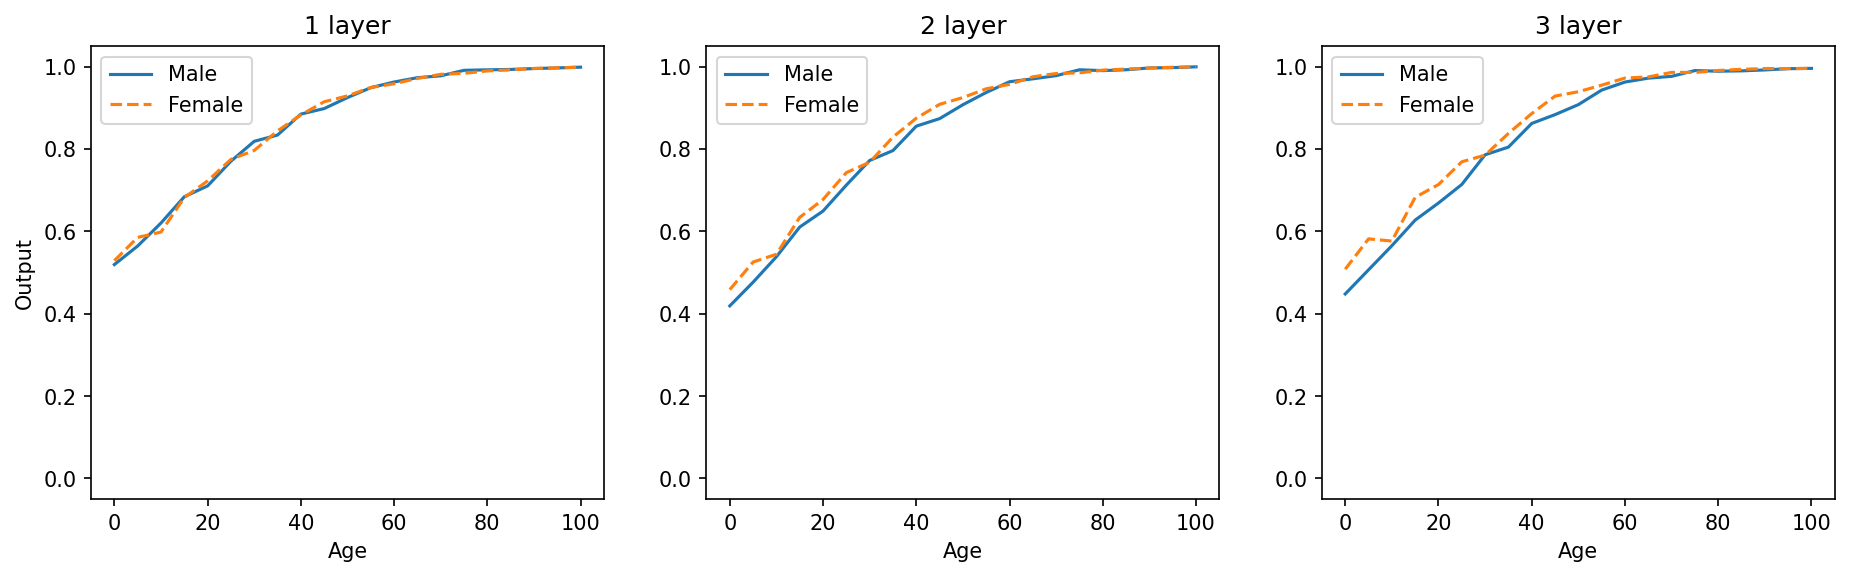

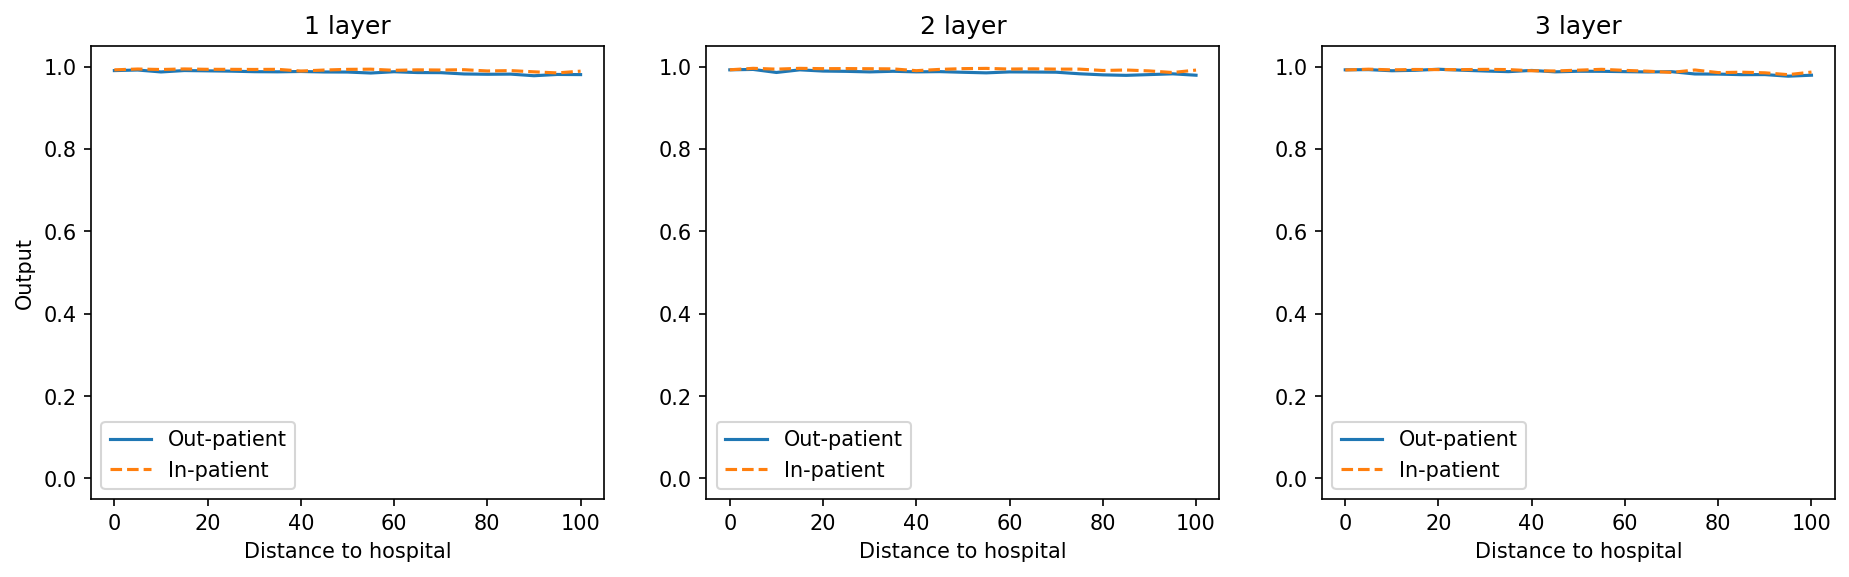

In [12]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_A_',
            legend_values=['Male', 'Female'], xlabel='Age', filename='results/plots/ag_A.png')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_A_',
           legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital', filename='results/plots/pd_A.png')

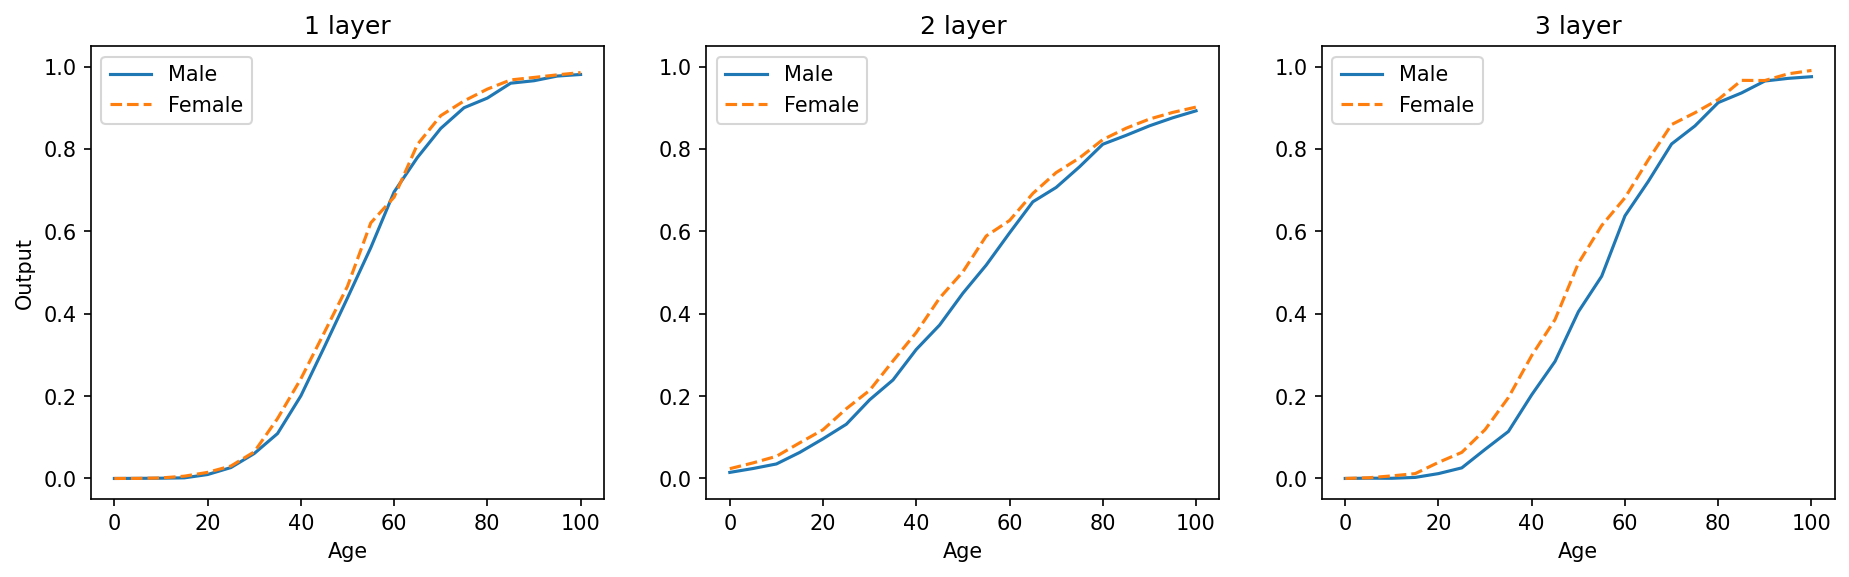

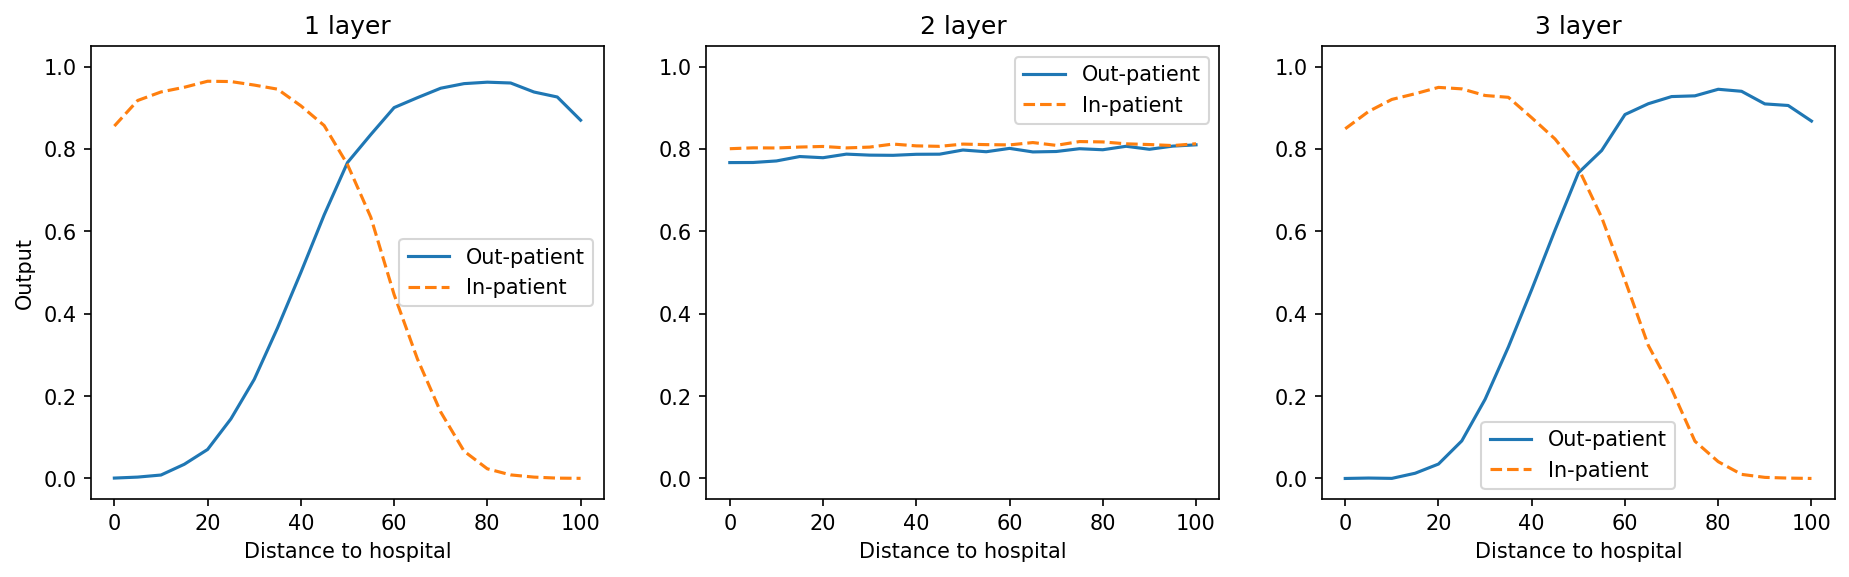

In [13]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_B_',
            legend_values=['Male', 'Female'], xlabel='Age', filename='results/plots/ag_B.png')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_B_',
            legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital', filename='results/plots/pd_B.png')

### Run the experiment multiple times

In [6]:
def convert_accs(accs):
    '''
    Converts list of accuracies to mean and std
    '''
    return str(round(np.mean(accs), 2)) + ' ± ' + str(round(np.std(accs), 2))   

def merge_accuracies(accuracies):
    '''
    Merge the list of accuracies to a pandas dataframe with mean and standard deviations
    '''
    accs = copy.deepcopy(accuracies)
    results = accs[0]
    for idx, x in enumerate(accs):
        if idx == 0: continue
        for train_name, train_data in x.items():
            for test_name, test_data in train_data.items():
                results[train_name][test_name].append(test_data[0])
                if idx == len(accs)-1:
                    results[train_name][test_name] = convert_accs(results[train_name][test_name])
    return pd.DataFrame.from_dict(results).T

def run_experiment(scaler):
    '''
    Train and test neural networks
    '''

    accuracies = {}

    # Training datasets
    datasets_train = {
        'train_A' : create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise),
        'train_B' : create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise),
    }
    preprocessed_train = {name: preprocess(df, scaler) for name, df in datasets_train.items()}

    # Test datasets
    datasets_test = {
        'test_A' : create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise),
        'test_B' : create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise),
        'ag' : create_age_gender_dataset(db_size=1000, n_noise=n_noise),
        'pd' : create_patient_distance_dataset(db_size=1000, n_noise=n_noise),   
    }
    preprocessed_test = {name: preprocess(df, scaler) for name, df in datasets_test.items()}
    
    for train_name, train_data in preprocessed_train.items():       
        # Create and train the neural networks on training set A
        neural_nets = [create_network(hls) for hls in hidden_layers]   
        neural_nets = Parallel(n_jobs=1)(delayed(train_networks)(nn, train_data[0], train_data[1]) 
                                         for nn in neural_nets)
        
        # Initialize accuracies data
        for idx, nn in enumerate(neural_nets):
            accuracies[train_name+'_'+str(idx+1)] = {test_name: [] for test_name in preprocessed_test.keys()}

        # Add accuracies
        for test_name, test_data in preprocessed_test.items():
            for idx, nn in enumerate(neural_nets):
                accuracies[train_name+'_'+str(idx+1)][test_name].append(100*accuracy_score(test_data[1], nn.predict(test_data[0])))

    return accuracies

In [7]:
# Number of runs
num_runs = 50
db_size = 2400

# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))   
accuracies = Parallel(n_jobs=-1)(delayed(run_experiment)(scaler) for run in tqdm(range(0, num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/50_runs.csv')
results

100%|██████████| 50/50 [01:29<00:00,  1.79s/it] 


,test_A,test_B,ag,pd
train_A_1,98.88 ± 0.21,72.35 ± 1.51,51.79 ± 3.33,50.04 ± 0.11
train_A_2,98.8 ± 0.24,71.99 ± 1.88,52.45 ± 4.09,50.06 ± 0.13
train_A_3,98.89 ± 0.23,71.02 ± 1.74,50.34 ± 2.78,50.02 ± 0.09
train_B_1,96.16 ± 0.65,90.65 ± 0.7,86.29 ± 1.22,86.69 ± 0.92
train_B_2,95.42 ± 0.81,89.08 ± 1.96,85.55 ± 1.19,81.35 ± 10.94
train_B_3,94.77 ± 6.1,87.09 ± 5.56,84.81 ± 3.74,74.94 ± 12.26


In [8]:
# Run the experiment again for the same amount of runs with more data
db_size = 50000

# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))   
accuracies = Parallel(n_jobs=-1)(delayed(run_experiment)(scaler) for run in tqdm(range(0, num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/50_runs_more_data.csv')
results

100%|██████████| 50/50 [12:24<00:00, 14.88s/it] 


,test_A,test_B,ag,pd
train_A_1,99.8 ± 0.03,80.98 ± 1.47,60.22 ± 3.87,64.44 ± 2.87
train_A_2,99.79 ± 0.04,83.49 ± 1.86,65.04 ± 5.12,66.5 ± 3.24
train_A_3,99.78 ± 0.05,82.89 ± 2.05,64.45 ± 5.6,64.2 ± 3.1
train_B_1,99.64 ± 0.17,98.53 ± 0.15,98.51 ± 0.47,97.17 ± 0.46
train_B_2,99.28 ± 0.36,98.06 ± 0.35,97.75 ± 0.9,96.53 ± 0.75
train_B_3,98.95 ± 0.55,97.5 ± 0.4,96.72 ± 1.0,95.73 ± 0.86
